In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Mounted at /content/drive
Looking for data in: /content/drive/MyDrive/apple
Loading Training Data...
Found 4024 files belonging to 2 classes.
Loading Validation Data...
Found 134 files belonging to 2 classes.
Loading Test Data...
Found 880 files belonging to 2 classes.
Classes found: ['fresh', 'rotten']
Computed Class Weights: {0: np.float64(1.2047904191616767), 1: np.float64(0.8547153780798641)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Starting Smart Training...
Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8734 - loss: 0.2949
Epoch 1: val_accuracy improved from -inf to 0.94776, saving model to /content/drive/MyDrive/apple/best_apple_resnet50.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 823s 6s/step - accuracy: 0.8739 - loss: 0.2938 - val_accuracy: 0.9478 - val_loss: 0.1012
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9734 - loss: 0.0743
Epoch 2: val_accuracy improved from 0.94776 to 0.96269, saving model to /content/drive/MyDrive/apple/best_apple_resnet50.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 794s 6s/step - accuracy: 0.9734 - loss: 0.0743 - val_accuracy: 0.9627 - val_loss: 0.0822
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9869 - loss: 0.0462
Epoch 3: val_accuracy improved from 0.96269 to 0.97015, saving model to /content/drive/MyDrive/apple/best_apple_resnet50.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 792s 6s/step - accuracy: 0.9869 - loss: 0.0462 - val_accuracy: 0.9701 - va

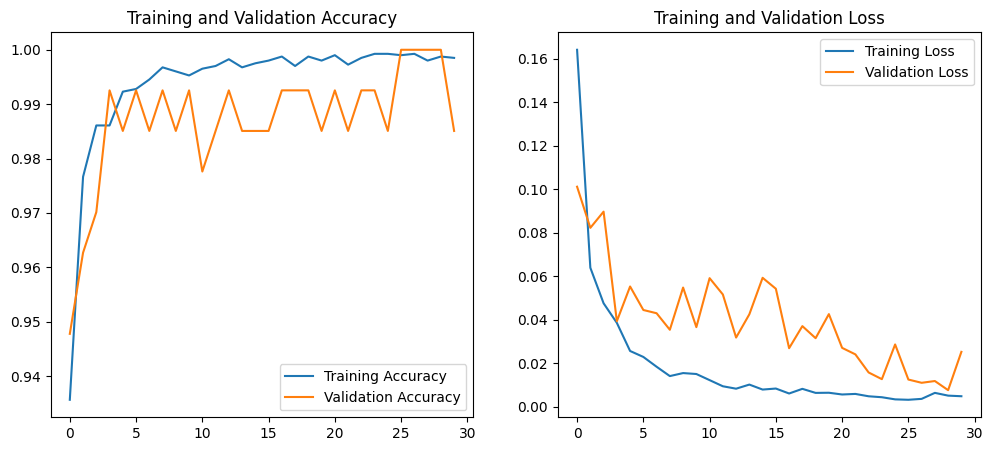


Generating Final Report on TEST Data...
28/28 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step


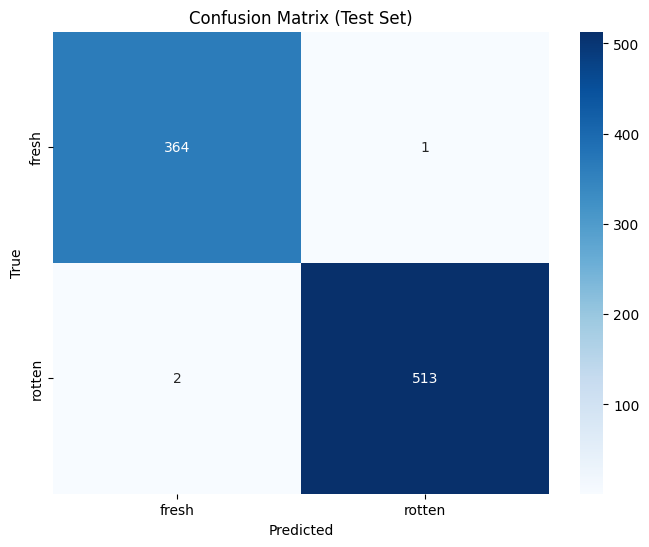

Classification Report:
              precision    recall  f1-score   support

       fresh       0.99      1.00      1.00       365
      rotten       1.00      1.00      1.00       515

    accuracy                           1.00       880
   macro avg       1.00      1.00      1.00       880
weighted avg       1.00      1.00      1.00       880



In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import seaborn as sns
import os

# 1. connecting google drive

drive.mount('/content/drive', force_remount=True)

# 2. setting paths

BASE_PATH = "/content/drive/MyDrive/apple"
TRAIN_DIR = os.path.join(BASE_PATH, 'training')
VAL_DIR   = os.path.join(BASE_PATH, 'validation')
TEST_DIR  = os.path.join(BASE_PATH, 'testing')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'best_apple_resnet50.keras')

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

# 3. loading data

print(f"Looking for data in: {BASE_PATH}")

try:
    print("Loading Training Data...")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

    print("Loading Validation Data...")
    val_ds = tf.keras.utils.image_dataset_from_directory(
        VAL_DIR,
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

    print("Loading Test Data...")
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        shuffle=False) # No shuffling

    class_names = train_ds.class_names
    print("Classes found:", class_names)

    # --- Imbalance Handling---
    # Getting labels
    y_train = []
    for _, label in train_ds.unbatch():
        y_train.append(label.numpy())

    y_train = np.array(y_train)

    # computing weights
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    train_class_weights = dict(enumerate(class_weights))
    print(f"Computed Class Weights: {train_class_weights}")

    # performance tuning
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # 4. data augmentation

    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
            layers.RandomRotation(0.2),
            layers.RandomZoom(0.2),
        ]
    )

    # 5. ResNet50

    base_model = tf.keras.applications.ResNet50(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = Sequential([
        data_augmentation,
        layers.Lambda(preprocess_input),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'), # more neurons
        layers.Dropout(0.3), # to reduce overfitting
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # slower learning rate for better learning
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # 6. callbacks

    callbacks = [
        EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True, verbose=1),
        ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
    ]

    # 7. training

    print("\nStarting Smart Training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        callbacks=callbacks,
        class_weight=train_class_weights
    )

    # 8. plot

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 9. evaluation

    print("\nGenerating Final Report on TEST Data...")

    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)

    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

except Exception as e:
    print(f" \n error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


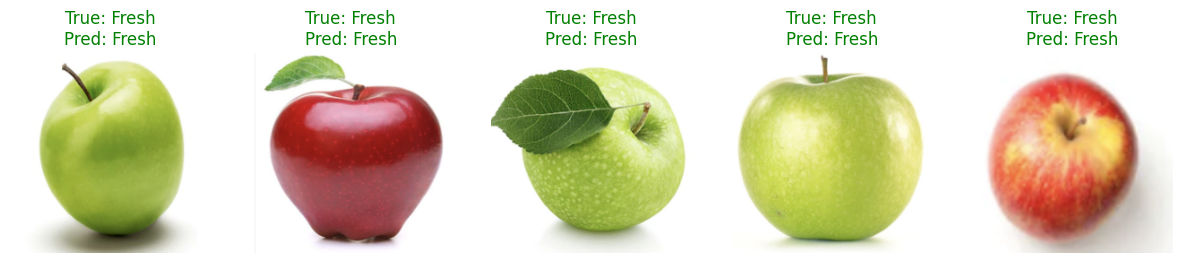

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# defining class names manually (because train_ds changed type after optimization)
class_names = ['Fresh', 'Rotten']

# Getting a batch of images from the test dataset
image_batch, label_batch = next(iter(test_ds))
predictions = model.predict(image_batch)
predicted_ids = np.argmax(predictions, axis=-1)

plt.figure(figsize=(15, 5))
for i in range(5):  # Display 5 images
    ax = plt.subplot(1, 5, i + 1)

    # Displaying the image
    plt.imshow(image_batch[i].numpy().astype("uint8"))

    # Getting true label and predicted label
    true_label = class_names[label_batch[i]]
    pred_label = class_names[predicted_ids[i]]

    # Green if correct, red if incorrect
    color = "green" if true_label == pred_label else "red"

    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


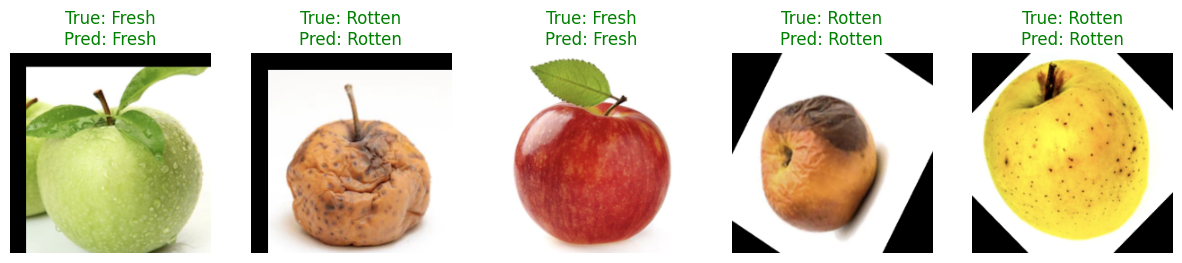

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining class names manually
class_names = ['Fresh', 'Rotten']

# Modification: take a random sample for visualization only
# (without affecting the original test set)
# skip(5) means skipping the first 5 batches (which are Fresh)
# or we use unbatch().shuffle() for temporary shuffling
visualization_ds = test_ds.unbatch().shuffle(1000).batch(32)

image_batch, label_batch = next(iter(visualization_ds))
predictions = model.predict(image_batch)
predicted_ids = np.argmax(predictions, axis=-1)

plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)

    plt.imshow(image_batch[i].numpy().astype("uint8"))

    true_label = class_names[label_batch[i]]
    pred_label = class_names[predicted_ids[i]]

    color = "green" if true_label == pred_label else "red"

    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.show()
